In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

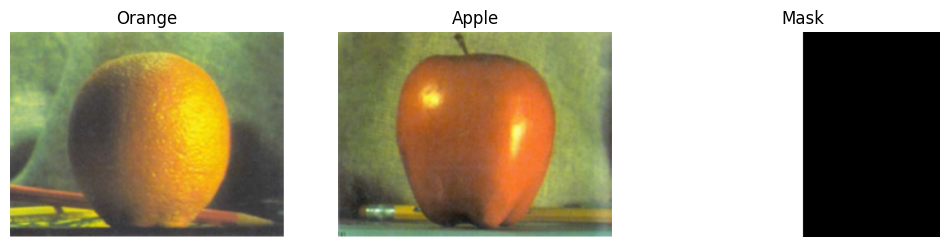

In [7]:
# Read the orange, apple, and mask images.
orange = cv2.imread('orange.png')
apple = cv2.imread('apple.png')
mask = cv2.imread('mask.png', cv2.IMREAD_GRAYSCALE)

# Resize images to have the same dimensions.
desired_width = 640
desired_height = 480
orange_resized = cv2.resize(orange, (desired_width, desired_height))
apple_resized = cv2.resize(apple, (desired_width, desired_height))
mask_resized = cv2.resize(mask, (desired_width, desired_height))

# Show the resized images
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(cv2.cvtColor(orange_resized, cv2.COLOR_BGR2RGB))
plt.title('Orange')
plt.axis('off')
plt.subplot(132)
plt.imshow(cv2.cvtColor(apple_resized, cv2.COLOR_BGR2RGB))
plt.title('Apple')
plt.axis('off')
plt.subplot(133)
plt.imshow(mask_resized, cmap='gray')
plt.title('Mask')
plt.axis('off')
plt.show()


In [10]:
# Downsample the input image by a factor of 2.
def pyrDown(image):
    height, width = image.shape[:2]
    new_height, new_width = height // 2, width // 2
    downsampled = cv2.resize(image, (new_width, new_height))
    return downsampled

# Upsample the input image by a factor of 2.
def pyrUp(image):
    height, width = image.shape[:2]
    new_height, new_width = height * 2, width * 2
    upsampled = cv2.resize(image, (new_width, new_height))
    return upsampled

# Build Gaussian pyramid.
def build_gaussian_pyramid(image, levels):
    pyramid = [image]
    for _ in range(levels):
        image = cv2.pyrDown(image)
        pyramid.append(image)
    return pyramid

# Build Laplacian pyramid.
def build_laplacian_pyramid(image, levels):
    gaussian_pyramid = build_gaussian_pyramid(image, levels)
    pyramid = [gaussian_pyramid[-1]]
    for i in range(levels, 0, -1):
        gaussian_expanded = cv2.pyrUp(gaussian_pyramid[i])
        laplacian = cv2.subtract(gaussian_pyramid[i-1], gaussian_expanded)
        pyramid.append(laplacian)
    return pyramid[::-1]



Laplacian Pyramid for Orange Image:


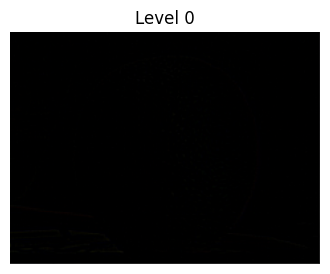

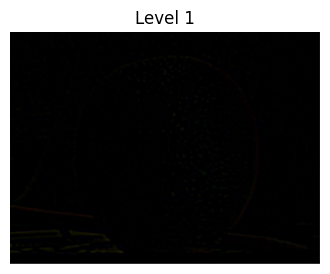

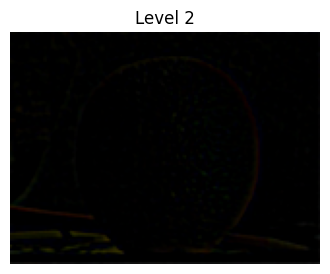

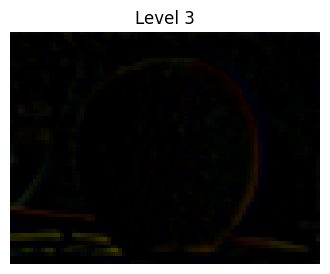

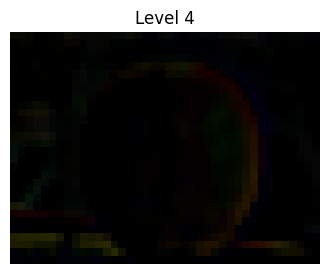

Laplacian Pyramid for Apple Image:


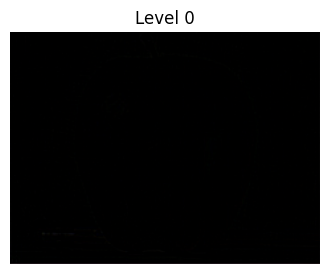

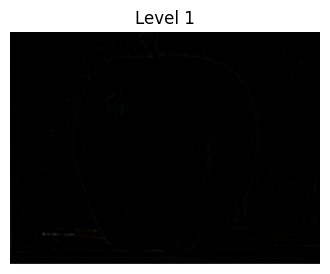

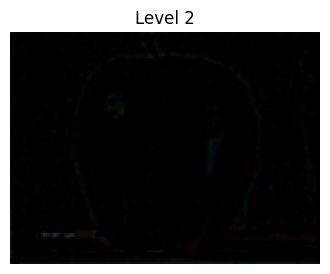

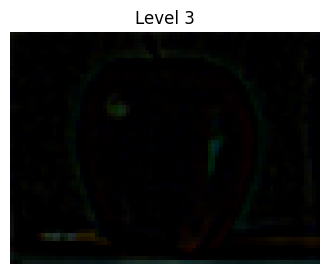

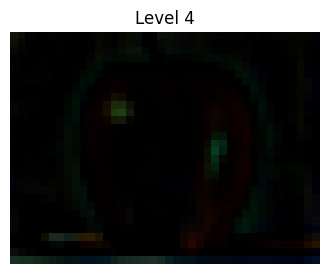

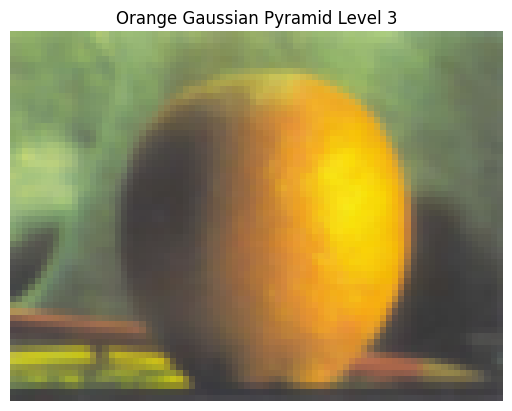

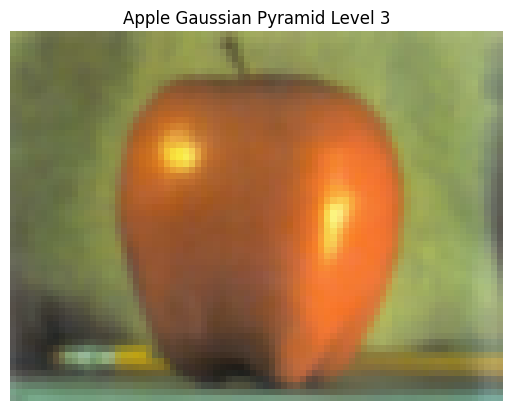

In [13]:
# Generate Gaussian pyramids for orange and apple images.
levels = 5  # Number of pyramid levels
orange_pyramid = build_gaussian_pyramid(orange_resized, levels)
apple_pyramid = build_gaussian_pyramid(apple_resized, levels)

# Generate Laplacian pyramids for orange and apple images.
orange_laplacian = build_laplacian_pyramid(orange_resized, levels)
apple_laplacian = build_laplacian_pyramid(apple_resized, levels)

# Print and display Laplacian pyramid for the orange image
print("Laplacian Pyramid for Orange Image:")
for i in range(levels):
    laplacian_level = cv2.normalize(orange_laplacian[i], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(laplacian_level, cv2.COLOR_BGR2RGB))
    plt.title(f"Level {i}")
    plt.axis('off')
    plt.show()

# Print and display Laplacian pyramid for the apple image
print("Laplacian Pyramid for Apple Image:")
for i in range(levels):
    laplacian_level = cv2.normalize(apple_laplacian[i], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(laplacian_level, cv2.COLOR_BGR2RGB))
    plt.title(f"Level {i}")
    plt.axis('off')
    plt.show()

# Generate Gaussian pyramid for the given mask image.
mask_pyramid = build_gaussian_pyramid(mask_resized, levels)

# Show an example level of the Gaussian pyramid for the orange image
plt.imshow(cv2.cvtColor(orange_pyramid[3], cv2.COLOR_BGR2RGB))
plt.title('Orange Gaussian Pyramid Level 3')
plt.axis('off')
plt.show()

# Show an example level of the Gaussian pyramid for the apple image
plt.imshow(cv2.cvtColor(apple_pyramid[3], cv2.COLOR_BGR2RGB))
plt.title('Apple Gaussian Pyramid Level 3')
plt.axis('off')
plt.show()

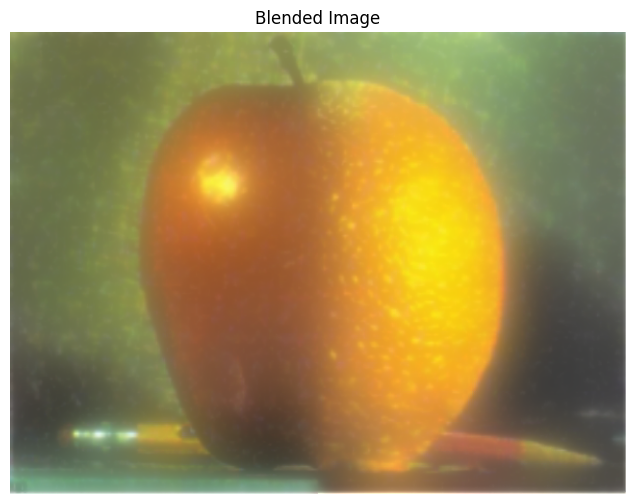

In [11]:
# Blend the Laplacian pyramids using the given mask pyramid.
blended_pyramid = []
for orange_level, apple_level, mask_level in zip(orange_laplacian, apple_laplacian, mask_pyramid):
    mask_level = cv2.cvtColor(mask_level, cv2.COLOR_GRAY2BGR)  # Convert mask to 3 channels.
    blended_level = orange_level * (1 - mask_level / 255) + apple_level * (mask_level / 255)
    blended_pyramid.append(blended_level)

# Reconstruct the blended image.
blended_image = blended_pyramid[-1].astype(np.float32)
for i in range(levels - 1, -1, -1):
    blended_image = cv2.pyrUp(blended_image)
    blended_image += blended_pyramid[i]

# Convert the blended image back to the uint8 data type
blended_image = np.clip(blended_image, 0, 255).astype(np.uint8)

# Display the blended image
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Blended Image')
plt.show()
